In [77]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

%matplotlib inline

In [69]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
btcUsd = pd.DataFrame(json.loads(res.content)['Data'])

In [71]:
btcUsd['time'] = pd.to_datetime(btcUsd['time'], unit='s')
btcUsd = btcUsd.drop(['conversionType', 'conversionSymbol'], axis=1)
target_col = 'close'

In [72]:
btcUsd.tail()

,time,high,low,open,volumefrom,volumeto,close
1996,2022-04-27,39465.62,37900.60,38117.39,34510.32,1.341341e+09,39252.04
1997,2022-04-28,40386.50,38892.10,39252.04,29981.12,1.188928e+09,39749.75
1998,2022-04-29,39922.60,38179.15,39749.75,24745.92,9.640201e+08,38594.22
1999,2022-04-30,38788.01,37607.77,38594.22,13696.14,5.252913e+08,37650.13
2000,2022-05-01,38668.00,37461.76,37650.13,10310.37,3.921524e+08,38334.41


<AxesSubplot:xlabel='time', ylabel='close'>

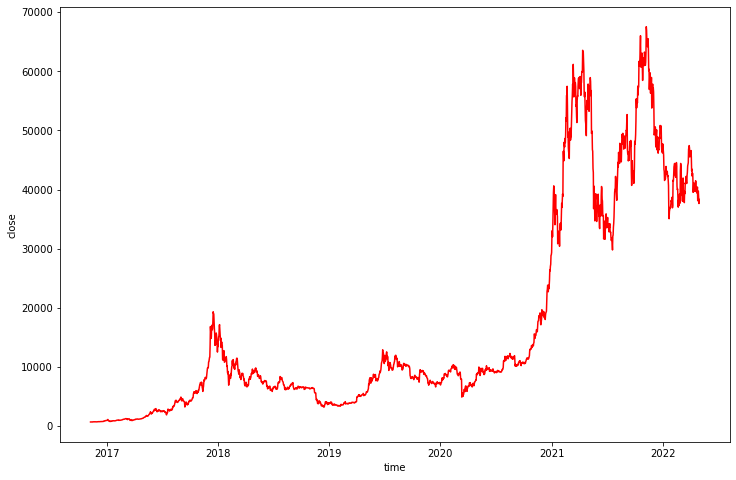

In [73]:
plt.figure(figsize=(12,8))
sns.lineplot(x='time', y='close', data=btcUsd, color='red')

In [39]:
SEQ_LEN = 50

In [40]:
def to_sequence(data, seq_len):
    d = []
    for idx in range(len(data) - seq_len):
        d.append(data[idx: idx + seq_len])
    return np.array(d)

In [65]:
def preprocess(raw_data, seq_len, train_split, targ_col):
    X = raw_data.drop(targ_col, axis=1)
    y = raw_data[targ_col]
    X_data = to_sequence(X, seq_len)
    y_data = to_sequence(y, seq_len)
    
    num_train =  int(len(data) * data.shape[0])
    
    X_train = X_data[:num_train, :-1, :]
    y_train = y_data[:num_train, -1].reshape(-1,1)
    
    X_test = X_data[num_train:, :-1, :]
    y_test = y_data[num_train:, -1].reshape(-1, 1)
    
    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = preprocess(btcUsd, SEQ_LEN, 0.8, target_col)

In [75]:
X_train.shape

(1951, 49, 6)

In [76]:
y_train.shape

(1951, 1)

In [80]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional

In [81]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN -1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape = (WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE * 2, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
